# Professions: comparison

In the following notebook we're going to compare all the approaches we developed and test them on a small amount of professions for which we have precise statics about. We will use both FastText's and Gonen's embeddings.

In [1]:
# general
import pandas as pd
import numpy as np
import scipy.stats
import codecs
from matplotlib import pyplot as plt
from numpy import linalg as LA

# bolukbasi's
import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding

# mine
import db_functions as db

### Step 1: Load embeddings

We load all the emdeddings using the same methods and applying the same preprocessing in order to have a common start.

In [2]:
# load FastText's emdeddings
E_wiki =  WordEmbedding('../embedding/fast-text/wiki.en.reduced.vec', 'ft')

*** Reading data from ../embedding/fast-text/wiki.en.reduced.vec
(157, 300)
157 words of dimension 300 : he, his, her, she, ..., dietitian, egoistic, broadminded, hardhearted
157 words of dimension 300 : he, his, her, she, ..., dietitian, egoistic, broadminded, hardhearted


### Step 2: working whit FastText's embeddings

#### Step 2.1: vector difference

In [4]:
# gender direction
g_diff = E_wiki.diff('he', 'she')

#### Step 2.2: PCA

In [6]:
# list of pairs to define gender
gender_pairs = [['he','she'],
                ['his','her'],
                ['man','woman'],
                ['john','mary'],
                ['himself','herself'],
                ['son','daughter'],
                ['father','mother'],
                ['guy','gal'],
                ['boy','girl'],
                ['male','female']]

In [7]:
# PCA
pca = we.doPCA(gender_pairs, E_wiki)

# PCA components
pc = pca.components_

# singular values
sv = pca.singular_values_

In [8]:
print("Singular values:")
print(sv)

Singular values:
[1.1442815  0.8523035  0.60972977 0.50737494 0.3993872  0.3585625
 0.33056718 0.24516939 0.19561277 0.15861395]


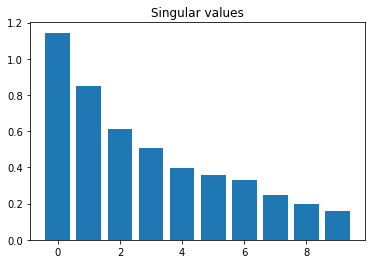

In [9]:
#fig = plt.figure(figsize=(10,7))    
plt.bar(range(pca.n_components_), sv)
plt.title("Singular values")
plt.show()
#fig.savefig('pca.png')

In [10]:
# gender direction
g_pca_0  = pc[0]/LA.norm(pc[0])

#### Step 2.4: compute projections

##### All professions

In [11]:
# read professions
prof_truth = db.read('professions_en.csv', 'truth')

In [12]:
# compute projection of each profession on g_diff
proj_g_diff = db.prof_proj(E_wiki, prof_truth, g_diff, 'istat')

# compute projection of each profession on g_pca_0
proj_g_pca_0 = db.prof_proj(E_wiki, prof_truth, g_pca_0, 'istat')

In [13]:
# print results
col0 = [] # pandas columns
col1 = []
col2 = []
col3 = []
col4 = []

for i in range(len(proj_g_diff)):
    col0.append(proj_g_diff[i][0]) # profession
    col1.append(proj_g_diff[i][1]) # projection on g_diff
    col2.append(proj_g_pca_0[i][1]) # projection on g_pca_0
    col3.append(proj_g_diff[i][2]) # %male
    col4.append(proj_g_diff[i][3]) # %female
    
data = {'Profession':col0, 
           'Proj g_diff':col1,
           'Proj g_pca_0':col2, 
           '% male':col3, 
           '% female':col4}
table = pd.DataFrame(data)
table

,Profession,Proj g_diff,Proj g_pca_0,% male,% female
0,trucker,-0.059179,-0.010548,93.3,6.7
1,electrician,0.077283,0.078696,97.8,2.2
2,engineer,0.131760,0.129596,84.3,15.7
3,architect,0.070402,0.079504,75.5,24.5
4,accountant,0.092888,0.065155,38.3,61.7
5,reporter,-0.049922,-0.084756,54.9,45.1
6,teacher,0.006748,-0.047777,19.5,80.5
7,bartender,-0.049371,-0.001636,49.9,50.1
8,physician,0.070181,0.032407,59.2,40.8
9,dentist,0.017646,-0.009330,66.1,33.9


In [14]:
# pearson correlation
r_g_diff = scipy.stats.pearsonr(col4, col1)[0]
r_g_pca_0 = scipy.stats.pearsonr(col4, col2)[0]

p_g_diff = scipy.stats.pearsonr(col4, col1)[1]
p_g_pca_0 = scipy.stats.pearsonr(col4, col2)[1]

In [15]:
pearson_data = {'g_diff':[r_g_diff,p_g_diff],
                'g_pca_0':[r_g_pca_0,p_g_pca_0]}
pearson_table = pd.DataFrame(pearson_data, index=['r','p'])
pearson_table

,g_diff,g_pca_0
r,-0.645954,-0.707377
p,0.001165,0.000232


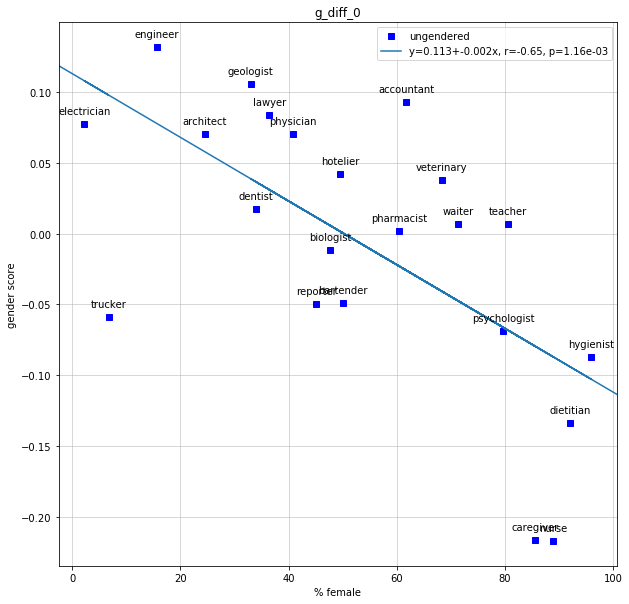

In [16]:
# correlation plot g_diff
slope, intercept, r, p, stderr = scipy.stats.linregress(col4, col1)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(col4, col1, linewidth=0, marker='s', color='blue', label='ungendered')
#ax.plot(np.array(col4), intercept + slope * np.array(col4), label=line)
xlims = plt.xlim()
x = [i for i in col4]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x), label=line)
plt.xlim(xlims)

ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.set_title("g_diff_0")
ax.legend()

for i, label in enumerate(col0):
    plt.annotate(label, # this is the text
                 (col4[i], col1[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
    
plt.show()
#fig.savefig('plot/ung/correlation/ft_g_diff')

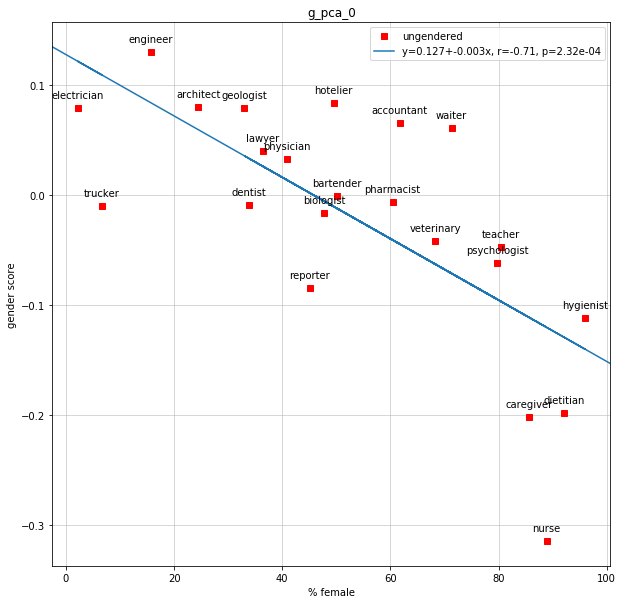

In [17]:
# correlation plot g_pca_0
slope, intercept, r, p, stderr = scipy.stats.linregress(col4, col2)
line = f'y={intercept:.3f}+{slope:.3f}x, r={r:.2f}, p={p:.2e}'

fig = plt.figure(figsize=(10,10))    
ax = fig.add_subplot(111)
ax.grid(linewidth=0.5)
ax.plot(col4, col2, linewidth=0, marker='s', color='red', label='ungendered')
#ax.plot(np.array(col4), intercept + slope * np.array(col4), label=line)
xlims = plt.xlim()
x = [i for i in col4]
x.insert(0, xlims[0])
x.append(xlims[1])
ax.plot(np.array(x), intercept + slope * np.array(x), label=line)
plt.xlim(xlims)
ax.set_xlabel('% female')
ax.set_ylabel('gender score')
ax.set_title("g_pca_0")
ax.legend(facecolor='white')

for i, label in enumerate(col0):
    plt.annotate(label, # this is the text
                 (col4[i], col2[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
#fig.savefig('plot/ung/correlation/ft_g_pca_0')